In [1]:
# import relative packages
import numpy as np
from gensim import corpora, models, similarities
from cheaters import dctConstr
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# loading frankenstein.txt
with open('frankenstein.txt', 'r', encoding='utf-8') as f:
    corp = f.read()

dct = dctConstr(stop_words=["i", "you", "a"], ignore_case=True)
dct.constructor(corp)

def split_by_paragraphs(data:str) -> []:
    processed=data.lower()
    while '\n\n\n' in processed:
        processed=processed.replace('\n\n\n','\n\n')
    out = processed.split('\n\n')
    return [o.replace("\n", " ") for o in out]

pcorp = split_by_paragraphs(corp)
pbow = [dct(para) for para in pcorp]
ptfidf = [dct.tfidf(para) for para in pcorp]
pvec = [dct.bow_to_vec(p) for p in pbow]
idx_to_terms = {i:j for j, i in dct.terms.items()} # flip dictionary for reversal
print(f"The corpus consists of {len(pvec[0])} terms and {len(pcorp)} documents")

The corpus consists of 7373 terms and 790 documents


In [4]:
# data preparing and processing
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in pcorp
]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

len(dictionary)
print(list(dictionary.values())[:10])
print(list(dct.terms.keys())[:10])

2023-01-09 13:37:21,563 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-01-09 13:37:21,907 : INFO : built Dictionary<11212 unique tokens: ['1', 'letter', '_to', 'england._', 'mrs.']...> from 790 documents (total 60190 corpus positions)
2023-01-09 13:37:21,909 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<11212 unique tokens: ['1', 'letter', '_to', 'england._', 'mrs.']...> from 790 documents (total 60190 corpus positions)", 'datetime': '2023-01-09T13:37:21.909284', 'gensim': '4.2.0', 'python': '3.7.15 (default, Nov 24 2022, 18:44:54) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


['1', 'letter', '_to', 'england._', 'mrs.', 'saville,', '11th,', '17—.', 'dec.', 'petersburgh,']
['⊹', '⊰', '⊱', '∃', '∀', '⊤', '⊥', '∊', '⋃', '⋼']


In [9]:
# calculate LDA by modeling
lda = models.ldamodel.LdaModel(corpus=pbow, id2word=idx_to_terms, num_topics=11)

2023-01-09 13:39:42,410 : INFO : using symmetric alpha at 0.09090909090909091
2023-01-09 13:39:42,413 : INFO : using symmetric eta at 0.09090909090909091
2023-01-09 13:39:42,423 : INFO : using serial LDA version on this node
2023-01-09 13:39:42,456 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 790 documents, updating model once every 790 documents, evaluating perplexity every 790 documents, iterating 50x with a convergence threshold of 0.001000
2023-01-09 13:39:42,458 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-09 13:39:45,073 : INFO : -10.901 per-word bound, 1911.7 perplexity estimate based on a held-out corpus of 790 documents with 70619 words
2023-01-09 13:39:45,074 : INFO : PROGRESS: pass 0, at document #790/790
2023-01-09 13:39:46,841 : INFO : topic #2 (0.091): 0.041*"of" + 0.041*"the" + 0.036*"and" + 0.030*"to" + 0.014*"in" + 0.013

In [12]:
# （optional）seperate date 80% for training and 20% for test sets
import random
random.seed(11) #set random seed
# shuffle corpus
cp = list(corpus)
random.shuffle(cp)

# split into 80% training and 20% test sets
p = int(len(cp) * .8)
cp_train = pbow[0:p]
cp_test = pbow[p:]
lda = models.ldamodel.LdaModel(corpus=cp_train, id2word=idx_to_terms, num_topics=11)

2023-01-09 13:59:11,868 : INFO : using symmetric alpha at 0.09090909090909091
2023-01-09 13:59:11,870 : INFO : using symmetric eta at 0.09090909090909091
2023-01-09 13:59:11,876 : INFO : using serial LDA version on this node
2023-01-09 13:59:11,902 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 632 documents, updating model once every 632 documents, evaluating perplexity every 632 documents, iterating 50x with a convergence threshold of 0.001000
2023-01-09 13:59:11,903 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-09 13:59:13,819 : INFO : -11.220 per-word bound, 2385.3 perplexity estimate based on a held-out corpus of 632 documents with 56872 words
2023-01-09 13:59:13,822 : INFO : PROGRESS: pass 0, at document #632/632
2023-01-09 13:59:15,324 : INFO : topic #6 (0.091): 0.025*"the" + 0.023*"and" + 0.020*"to" + 0.017*"my" + 0.016*"was" + 0.01

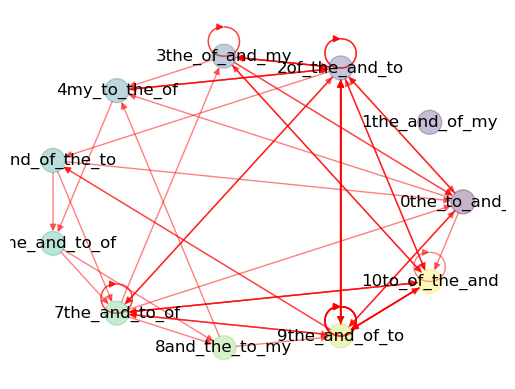

In [10]:
# plots visual network
import networkx as nx
from matplotlib import cm
import matplotlib.pyplot as plt

limit = 500  # number of paragraphs

def get_most_likely_topic(bow):
    mm = lda.get_document_topics(bow)
    s = sorted(mm, key=lambda x: x[1])
    if s:
        return s[0][0]
    else:
        return 0

topic_labels = []
for num in range(lda.num_topics):
    lab = lda.show_topic(num)
    topic_labels.append(str(num) + "_".join([i[0] for i in lab[:4]]))

viridis = cm.get_cmap('viridis', lda.num_topics)
newcolors = viridis(np.linspace(0, 1, lda.num_topics))

topic_sequence = [get_most_likely_topic(i) for i in pbow[:limit]]
labels = {num: i for num, i in enumerate(topic_labels)}

node_list = list(range(lda.num_topics))
nodecolor = newcolors
edge_list = []
for i in range(len(pbow[limit]) - 1):
    edge_list.append(
        (topic_sequence[i], topic_sequence[i + 1])
    )

G = nx.DiGraph()

# nodes
for i in range(lda.num_topics):
    G.add_node(i)
for i in edge_list:
    G.add_edge(i[0], i[1])

# pos = nx.spring_layout(G)
pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G,
                    pos,
                    nodelist=node_list,
                    node_color=nodecolor,
                    alpha=0.3)

nx.draw_networkx_edges(G, pos,
                       edgelist=edge_list,
                       width=1, alpha=0.5, edge_color='r')

nx.draw_networkx_labels(G, pos,
                        labels=labels, font_size=12)

plt.rcParams['figure.figsize'] = [15, 10]
plt.axis('off')
plt.show()